In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

# 1. 编码器

### 思路讲解：
**1. Embedding层**
- 把原始的“单词编号”变成“稠密向量”，让模型能感知单词之间的语义距离。就像从“傻瓜编号”变成“词语地图”。

**2. GRU堆叠**
- 输入嵌入序列，经过多层GRU，提取输入句子的“时序特征”。堆叠多层=模型更聪明。
- 可以设定层数，加入dropout（丢弃法，防过拟合）。

**3. 前向传播**
- 先embedding，再调整tensor维度：PyTorch里RNN输入要时间步优先（steps, batch, embed）。
- 最后扔进GRU，得到：
    - output：每个时刻的隐藏状态（可用于注意力机制等）
    - state：每层最后一步的隐藏状态（通常给decoder）

**4. 核心思想**
- 编码器就是把一句话“压缩”为有用的信息，供后续解码器解读。
- RNN（GRU/LSTM）负责捕捉“顺序和上下文”。
- 输出的状态代表“读完这句话，我记住了啥”。

In [2]:
'''Encoder'''
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        # 单词索引->稠密向量（嵌入层，学到单词之间的联系）
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 堆叠GRU：多个GRU层叠加，能学到更复杂的时序特征
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # X: (batch, steps) 例：[32, 10]
        X = self.embedding(X)            # (batch, steps, embed) 例：[32, 10, 16]
        X = X.permute(1, 0, 2)           # PyTorch的RNN喜欢时间步优先：(steps, batch, embed) 例：[10, 32, 16]
        output, state = self.rnn(X)      # output: 所有时刻的隐状态  (steps, batch, hidden)
                                         # state: 每层最后的隐状态 (num_layers, batch, hidden)
        return output, state


In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [4]:
state.shape

torch.Size([2, 4, 16])

# 2. 解码器

### 实现思路
**1. Decoder输入拼接context**
- 和encoder不一样，decoder每一步输入除了token embedding，还要加一个“全局context”——也就是encoder最后一层隐状态。这让每个解码步都能直接获得整句话信息。
- 实现：把state[-1]复制到每个时间步，然后拼接到input embedding后面。

**2. forward过程**
- X先embedding、然后调成(steps, batch, embed)。
- 拼上context，输入给GRU。
- Linear层把GRU输出变成预测下一个词的概率分布。

**3. init_state**
- 直接用encoder的最终隐藏状态作为decoder的初始隐状态——这样“翻译”能顺利衔接。

**4. 输出形状说明**
- output: (batch, steps, vocab_size) —— 每个解码步预测所有词概率。
- state: 传递到下一个时刻的隐状态。

### Embedding是什么
* **Embedding**：泛指“把离散的对象（如单词、token）转成稠密向量”，常用于神经网络输入。
* **Token Embedding**：就是把“token”（可以是单词、子词、字符等）转成稠密向量，token是什么就embed什么。
* **Word Embedding**：特指“单词级别”的embedding，即把单词变成向量，比如Word2Vec、GloVe。“Word embedding”专指token=单词的情况。





In [5]:
''' Decoder '''
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 解码器输入是(嵌入向量 + 上文context)，所以输入维度加大
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)   # 输出层，预测下一个词的概率分布

    def init_state(self, enc_outputs, *args):
        # 只用encoder输出的最后状态（state）初始化decoder的隐状态
        return enc_outputs[1]

    def forward(self, X, state):
        # X: (batch, steps) -> embedding + 交换轴 (steps, batch, embed)
        X = self.embedding(X).permute(1, 0, 2)

        # 拿encoder最后一层的隐状态，repeat到每个解码步
        # context: (steps, batch, num_hiddens)
        context = state[-1].repeat(X.shape[0], 1, 1)

        # 拼接输入和context向量（在特征维上拼，搞成[embedding + context]）
        X_and_context = torch.cat((X, context), 2)

        # 送进GRU，得到新的output和state
        output, state = self.rnn(X_and_context, state)

        # output: (steps, batch, num_hiddens) -> 经过Linear变为(vocab分布) -> 变成(batch, steps, vocab)
        output = self.dense(output).permute(1, 0, 2)
        return output, state



In [6]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

# 3. 损失函数

* 用于处理变长序列（比如有的句子7个词，有的10个），让padding部分不会参与计算。

In [7]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项（padding的位置填value）"""
    maxlen = X.size(1)  # 序列最大长度
    # mask: (batch, maxlen) 每个位置判断是否小于有效长度
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    # 将无效部分（padding部分）赋值为value（通常为0）
    X[~mask] = value
    return X


X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [8]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

* 只对非padding部分计算loss，避免无效的padding影响模型学习。
* 先用mask确定有效部分，然后loss按mask加权，最后按句子求均值。

In [9]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失（只对有效token算loss）"""
    # pred: (batch, steps, vocab)   label: (batch, steps)   valid_len: (batch, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)                    # 先全为1
        weights = sequence_mask(weights, valid_len)         # 只有有效token为1，padding为0
        self.reduction='none'                              # 不聚合，逐步输出loss
        # 交叉熵：输入(batch, vocab, steps)和(batch, steps)
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1) # 只对有效部分求平均
        return weighted_loss


In [10]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

# 4. 训练

In [11]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练seq2seq模型"""

    # ----------- 参数初始化 -----------
    def xavier_init_weights(m):
        # 用Xavier方法初始化Linear和GRU权重，防止梯度消失/爆炸
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)                                 # 模型丢到GPU/CPU
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # 优化器
    loss = MaskedSoftmaxCELoss()                   # 损失函数（遮蔽padding）
    net.train()                                    # 训练模式
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])

    # ----------- 训练主循环 -----------
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 记录：总损失/总token数
        for batch in data_iter:
            optimizer.zero_grad()     # 梯度清零
            # 数据批次搬到设备上
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # 处理Decoder输入，加上<BOS>（强制教学：前一时刻真实输出作为当前输入）
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # [BOS, y1, y2,...]
            # 模型前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()        # 损失反向传播（sum成标量）
            d2l.grad_clipping(net, 1) # 梯度裁剪（防爆炸）
            num_tokens = Y_valid_len.sum()  # 本批次总token数
            optimizer.step()          # 参数更新

            # 记录损失和token数
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)

        # 画loss曲线
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')


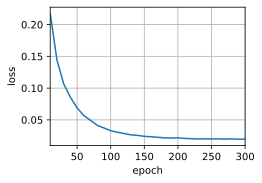

In [12]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# 5. 预测

## 关键思路总结
* 输入：源句子→分词→编号→补齐（pad/truncate）→加batch维
* 编码器：编码整个输入序列，得到隐藏状态
* 解码器：每步用上一步预测作为输入（初始用<BOS>），step by step生成新token
* 终止条件：遇到<EOS>或步数用完就停
* 最终输出：token id 转字符串

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测（翻译/生成）"""
    net.eval()  # 评估模式，关掉dropout等

    # 1. 源句子编码成token id，并加<eos>
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)  # 有效长度
    # 2. 长度不足补pad，多了截断，保证长度一致
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)  # (1, steps)

    # 3. 编码器forward，获得隐藏状态
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # 4. 解码器初始化state
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

    # 5. 解码输入初始为<BOS>
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)

    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        # 6. 解码器forward，生成下一个token分布
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 7. 选概率最大的token，作为下一个输入
        dec_X = Y.argmax(dim=2)  # (1,1)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()  # 转成int
        # 8. 保存注意力（如果需要可视化）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 9. 如果预测到<EOS>，停止生成
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    # 10. 转回字符串
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# 6. 预测序列的评估

## 主要思路
- BLEU分数衡量预测和参考答案的“n-gram”重叠程度（翻译/文本生成常用指标）。
- 惩罚机制：如果你生成的句子比答案短太多，直接指数级扣分（避免只输出“你好”这种）。
- n-gram匹配：统计1-gram、2-gram……k-gram的“命中率”，再用不同权重累乘。
- 分数越高表示生成越像答案。

In [ ]:
def bleu(pred_seq, label_seq, k):
    """计算BLEU分数，评估生成句子的好坏（常用于机器翻译）"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    # 惩罚过短的预测：短得离谱时分数直接低
    score = math.exp(min(0, 1 - len_label / len_pred))
    # n-gram累乘打分
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        # 统计label里的所有n-gram短语出现次数
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        # 看pred里的n-gram有多少能在label里找到
        for i in range(len_pred - n + 1):
            ngram = ' '.join(pred_tokens[i: i + n])
            if label_subs[ngram] > 0:
                num_matches += 1
                label_subs[ngram] -= 1
        # precision：预测n-gram中有多少匹配
        # 权重越高的n越难匹配（通常1-gram和2-gram比重最大）
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')